# Modèle épidémiologique (SIRD)

Etrangement, il n'était pas possible d'accéder aux données de l'épidémie le jour du TD car le site [data.gouv.fr](https://www.data.gouv.fr/fr/) était inacessible suite à une [panne chez OVH](https://www.lemonde.fr/pixels/article/2021/10/13/le-fournisseur-de-services-cloud-et-hebergeur-ovhcloud-touche-par-une-panne_6098154_4408996.html).

* $\frac{dS}{dt} = - \beta \frac{S I}{N}$
* $\frac{dI}{dt} = \frac{\beta S I}{N} - \mu I - \nu I$
* $\frac{dD}{dt} = \nu I$
* $\frac{dR}{dt} = \mu I$

Comme les vraies données sont inaccessibles, on s'intéresse à des données simulées.

### Simulation

In [3]:
import numpy


def iteration(S, I, R, D, beta, mu, nu, N):
    dR = I * mu
    dD = I * nu
    dS = -S * I * beta / N
    dI = -dS - dR - dD
    return S + dS, I + dI, R + dR, D + dD


iteration(10, 1, 0, 0, 0.1, 0.1, 0.1, 11)

(9.909090909090908, 0.8909090909090909, 0.1, 0.1)

In [4]:
def simulation(n_iter, S, I, R, D, beta, mu, nu):
    sim = numpy.zeros((n_iter + 1, 4))
    sim[0, :] = numpy.array([S, I, R, D]).ravel()
    N = S + I + R + D
    for i in range(n_iter):
        S, I, R, D = iteration(S, I, R, D, beta, mu, nu, N)
        sim[i + 1, :] = numpy.array([S, I, R, D]).ravel()
    return sim


simulation(2, 10, 1, 0, 0, 0.1, 0.1, 0.1)

array([[10.        ,  1.        ,  0.        ,  0.        ],
       [ 9.90909091,  0.89090909,  0.1       ,  0.1       ],
       [ 9.82883546,  0.79298272,  0.18909091,  0.18909091]])

### Visualisation

In [5]:
%matplotlib inline

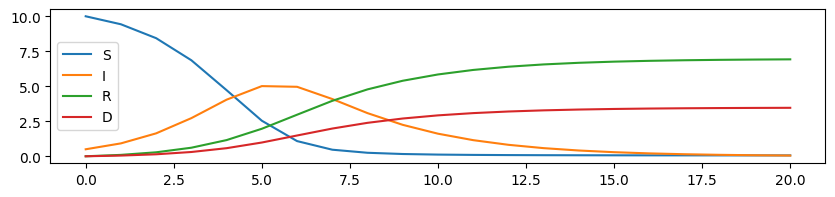

In [7]:
import matplotlib.pyplot as plt
import pandas

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
sim = simulation(20, 10, 0.5, 0, 0, 1.2, 0.2, 0.1)
df = pandas.DataFrame(sim, columns=["S", "I", "R", "D"])
df.plot(ax=ax);

### Estimation des paramètres

Une fois qu'on a des données, on peut essayer de retrouver la paramètres de la simulation. Mais auparavant, on simule des données un peu plus bruitées en changeant les paramètres du modèle tous les jours.

In [8]:
def simulation_bruitee(n_iter, S, I, R, D, beta, mu, nu):
    sim = numpy.zeros((n_iter + 1, 4))
    sim[0, :] = numpy.array([S, I, R, D]).ravel()
    N = S + I + R + D
    for i in range(n_iter):
        b = numpy.random.randn(1) * beta / 5 + beta
        m = numpy.random.randn(1) * mu / 5 + mu
        n = numpy.random.randn(1) * nu / 5 + nu
        S, I, R, D = iteration(S, I, R, D, b, m, n, N)
        sim[i + 1, :] = numpy.array([S, I, R, D]).ravel()
    return sim


simulation_bruitee(2, 10, 1, 0, 0, 0.1, 0.1, 0.1)

array([[10.        ,  1.        ,  0.        ,  0.        ],
       [ 9.90629495,  0.90818313,  0.0769856 ,  0.10853633],
       [ 9.84322669,  0.77113049,  0.17022418,  0.21541865]])

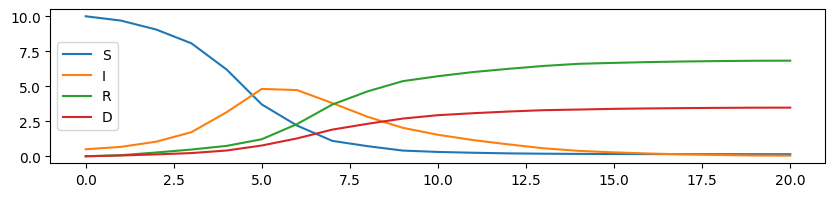

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
sim_bruit = simulation_bruitee(20, 10, 0.5, 0, 0, 1.2, 0.2, 0.1)
df = pandas.DataFrame(sim_bruit, columns=["S", "I", "R", "D"])
df.plot(ax=ax);

#### Première idée

On calcule les paramètres chaque jour à partir de la définition du modèle.

In [10]:
def estimation_coefficient(sim):
    N = sim.sum(axis=1)
    diff = sim[1:] - sim[:-1]
    mu = diff[:, 2] / sim[:-1, 1]
    nu = diff[:, 3] / sim[:-1, 1]
    beta = -diff[:, 0] / (sim[:-1, 1] * sim[:-1, 0]) * N[:-1]
    return dict(beta=beta, mu=mu, nu=nu)


df = pandas.DataFrame(estimation_coefficient(sim_bruit))
df.head(n=1)

,beta,mu,nu
0,0.645167,0.153483,0.113224


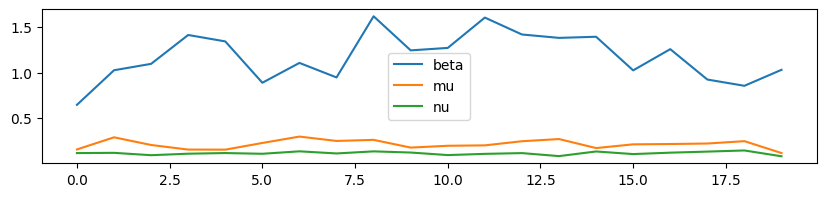

In [11]:
df.plot(figsize=(10, 2));

On pourrait imaginer que les paramètres cherchés soient égaux à la moyenne des valeurs obtenues pour chaque jour. Encore faudrait-il le prouver ou trouver un contre exemple.

#### Seconde idée : problèmes d'optimisation

On cherche à transformer le problème d'estimation en un problème d'optimisation de telle sorte que les paramètres en sont la solution. L'idée de simuler en fonction d'un jeu de paramètres puis de calculer une distance entre cette simulation et les données observées.

Le problème de cette solution est qu'il faut essayer plein de valeur, au hasard pour faire simple. Donc on se sert de la fonction précédente comme point de départ et on tire des valeurs tout autour.

In [12]:
def distance_sim(obs, sim):
    return ((obs - sim) ** 2).sum() / obs.size


distance_sim(sim, sim_bruit)

0.1379327480825296

In [13]:
def optimisation(obs):
    est = estimation_coefficient(obs)
    b0 = est["beta"].mean()
    m0 = est["mu"].mean()
    n0 = est["nu"].mean()
    n_iter = obs.shape[0] - 1
    S, I, R, D = obs[0]
    beta, mu, nu = b0, m0, n0
    distance = distance_sim(obs, simulation(n_iter, S, I, R, D, b0, m0, n0))
    distance0 = distance
    for i in range(0, 100):
        b = numpy.random.randn(1) * b0 / 5 + b0
        m = numpy.random.randn(1) * m0 / 5 + m0
        n = numpy.random.randn(1) * n0 / 5 + n0
        sim = simulation(n_iter, S, I, R, D, b, m, n)
        d = distance_sim(obs, sim)
        if distance is None or d < distance:
            distance = d
            beta, mu, nu = b, m, n
    return dict(
        b0=b0,
        mu0=m0,
        nu0=n0,
        beta=beta,
        mu=mu,
        nu=nu,
        distance=distance,
        distance0=distance0,
    )


optimisation(sim_bruit)

{'b0': 1.175492030437819,
 'mu0': 0.21093122422461147,
 'nu0': 0.11141742761811038,
 'beta': array([1.12240477]),
 'mu': array([0.1995322]),
 'nu': array([0.09668045]),
 'distance': 0.06764482535407212,
 'distance0': 0.0880922396685696}

`distance0` la distance entre la simulation obtenue avec les paramètes de la première méthode, `distance` celle de la seconde et elle est plus petite. Cela répond à la question qu'on se posait ci-dessus.